In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display
import stumpy
import os
import zipfile

np.set_printoptions(suppress=True)

data_directory = './data/Feb2022/'

In [13]:
# Unzip all the contents of the data folder

for file in os.listdir(data_directory):

    if "zip" not in file:
        continue
    
    with zipfile.ZipFile(data_directory + file, 'r') as zip_ref:
        zip_ref.extractall(data_directory)
    os.remove(data_directory + file)

In [60]:
def do_matrix_profile(df, m):
    mps, indices = stumpy.mstump(df, m)
    motifs_idx = np.argsort(mps, axis=1)[:, 0]
    nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

    fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(18,80))

    for k, dim_name in enumerate(df.columns):
        axs[k].set_ylabel(dim_name, fontsize='8')
        axs[k].plot(np.arange(df.shape[0]), df[dim_name])
        axs[k].set_xlabel('Time', fontsize ='8')

        axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='8')
        axs[k + mps.shape[0]].plot(mps[k], c='orange')
        axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='8')

        # axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
        # axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
        # axs[k + mps.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
        # axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

        # if dim_name != 'T3':
        #     axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
        #     axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        #     axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
        #     axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')
        # else:
        #     axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='black')
        #     axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='black')

    plt.show()

In [41]:
def read_in_file(filename, keep_columns=None):
    df = pd.read_csv(filename)

    if "time" in df.columns.tolist():
        df.time = pd.to_datetime(df.time, format='%Y-%m-%dT%H:%M:%S.%f')

    df = df.set_index('time')

    if keep_columns is not None:
        drop_columns = list( set(df.columns.tolist()) - set(keep_columns) )
        df = df.drop(columns=drop_columns)

    return df

In [39]:
def groupby_second(df):
    df = df.groupby(by=[df.index.year, df.index.month, df.index.day, df.index.hour, df.index.minute, df.index.second]).agg('mean')
    df.index = pd.to_datetime(df.index.get_level_values(0).astype(str) + '-' +
                df.index.get_level_values(1).astype(str) + '-' +
                df.index.get_level_values(2).astype(str) + 'T' +
                df.index.get_level_values(3).astype(str) + ':' +
                df.index.get_level_values(4).astype(str) + ':' +
                df.index.get_level_values(5).astype(str),
                format='%Y-%m-%dT%H:%M:%S')
    return df

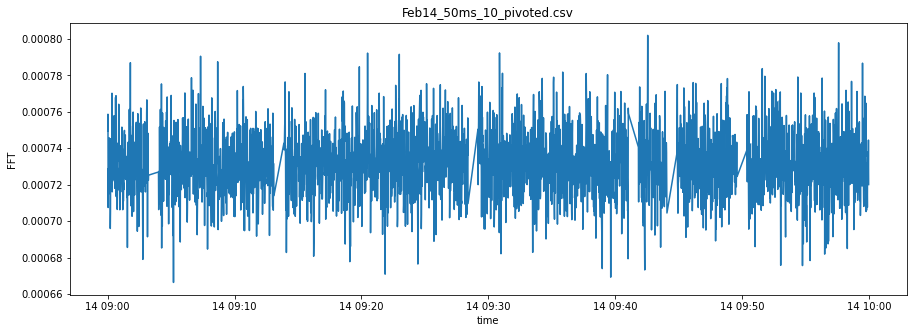

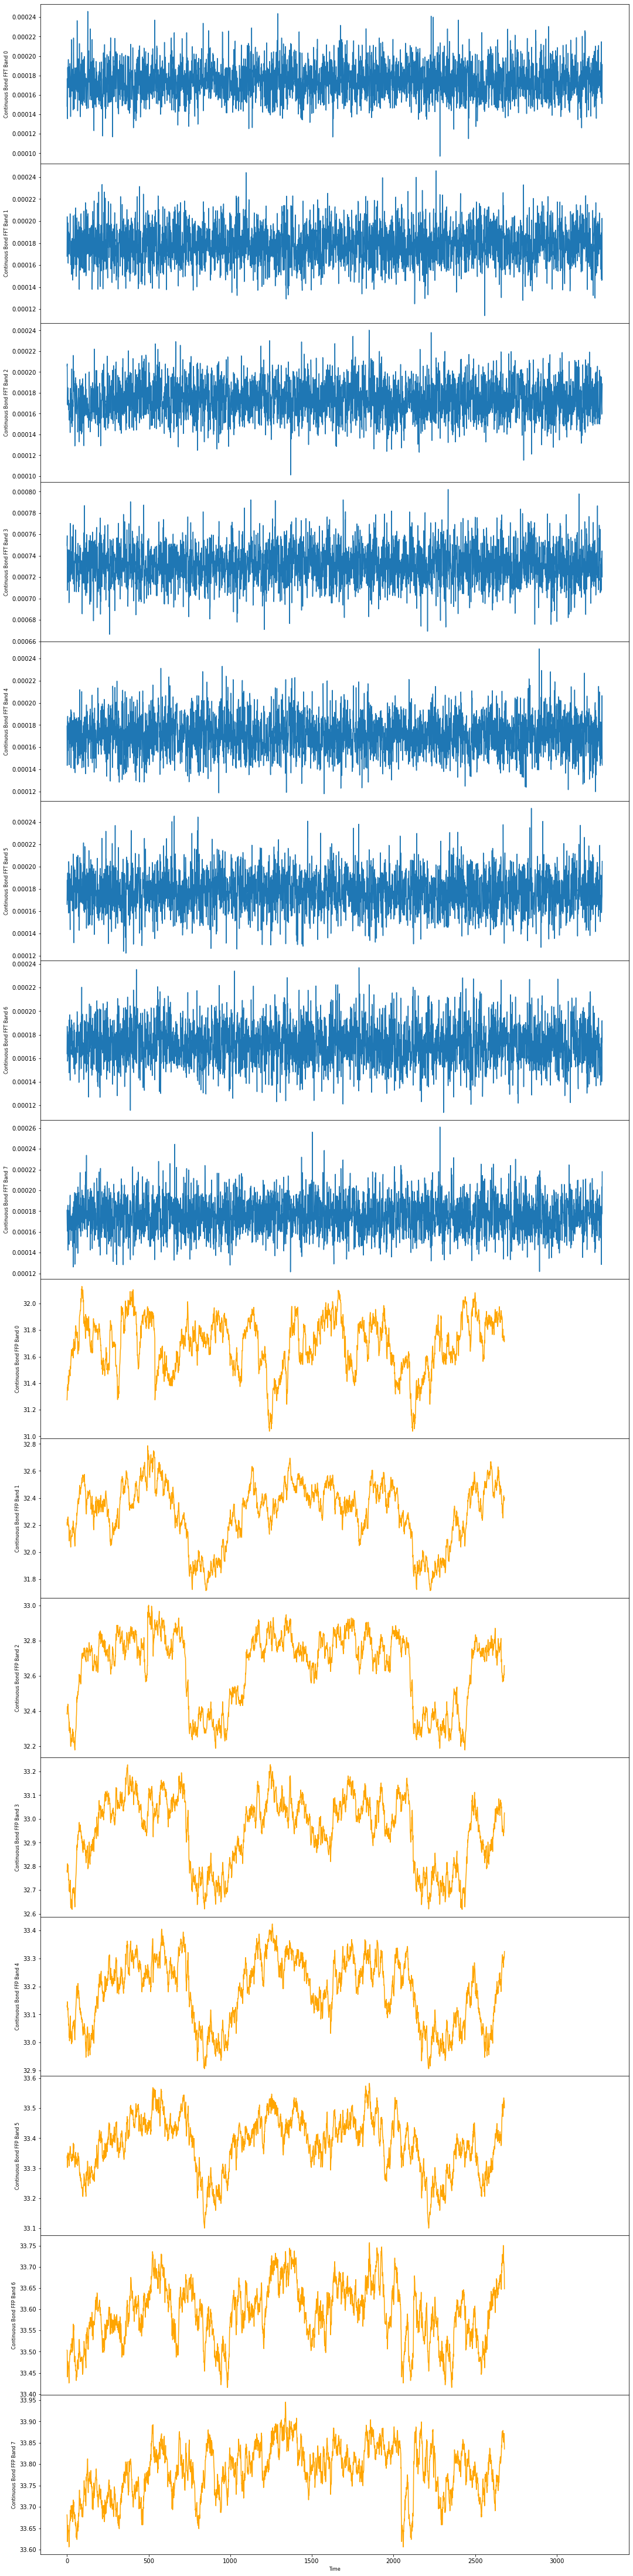

,Bonding Roll Actual Velocity,Bonding Roll Command Velocity,Bonding Roll Position Error,Bonding Roll Torque
time,,,,
2022-02-14 09:00:00.003990,0.0,0.0,0.0,0.0


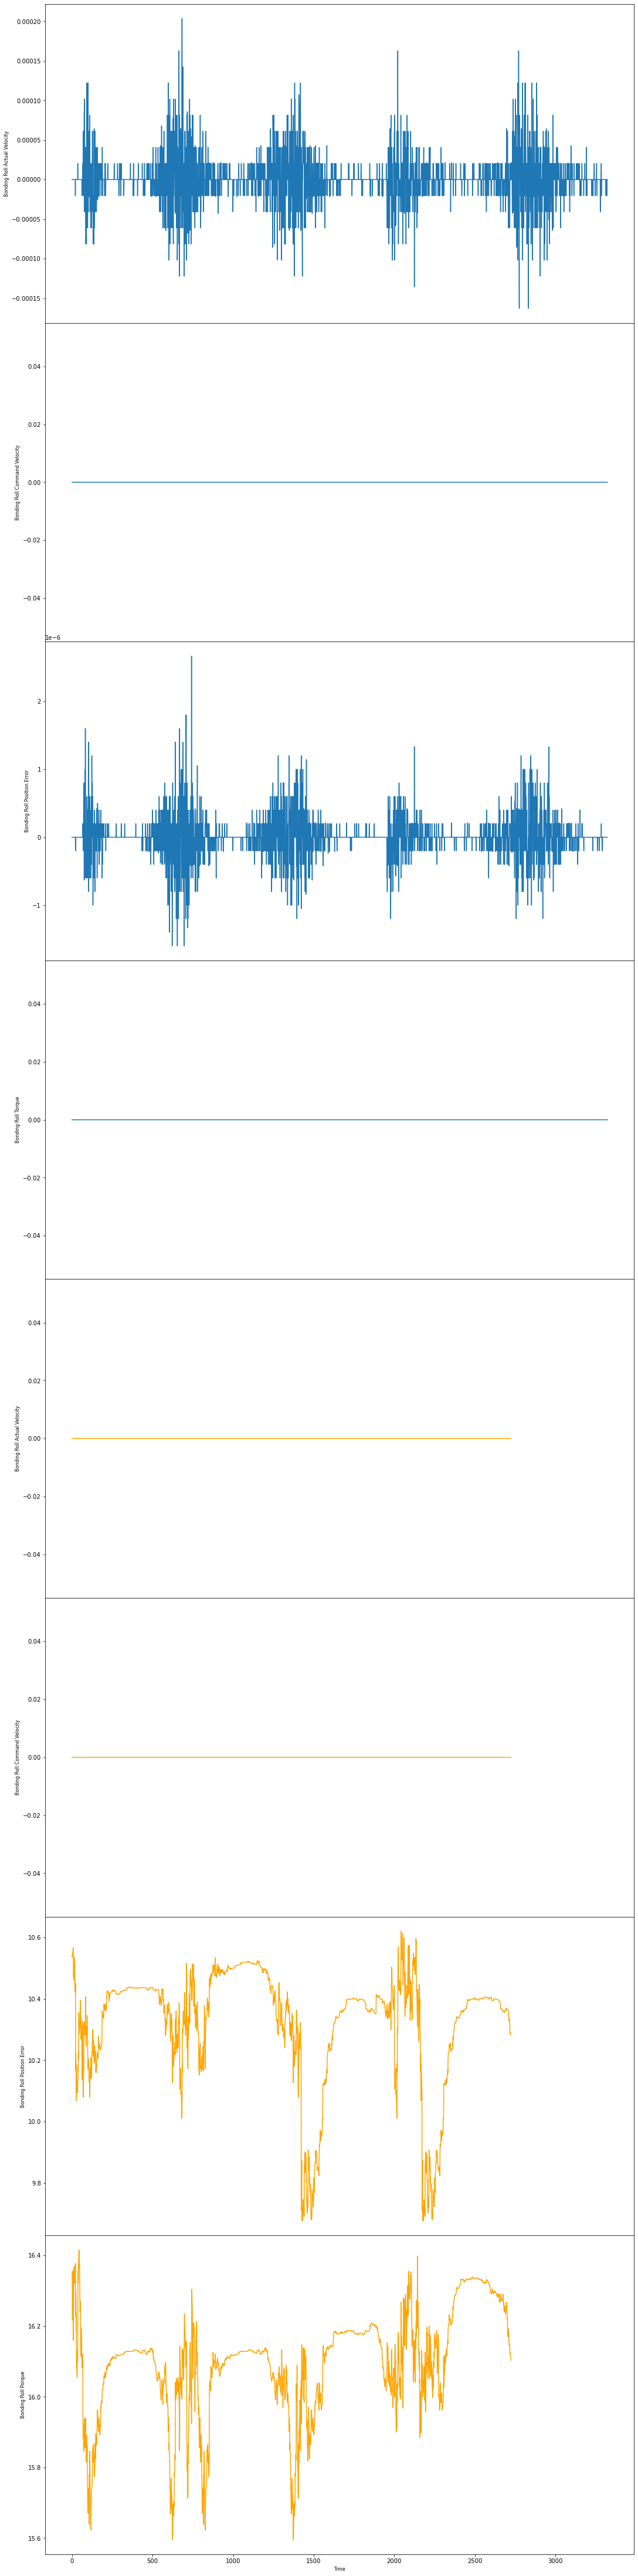

In [61]:
for file in os.listdir(data_directory):
    df = read_in_file(data_directory + file, ['Continuous Bond FFT Band ' + str(i) for i in range(8)])
    # df = read_in_file(data_directory + file)
    # df = df.iloc[1::2]
    df = df.dropna()
    df = groupby_second(df)

    figure(figsize=(15,5))
    plt.plot(df.index, df['Continuous Bond FFT Band 3'])
    plt.title(file)
    plt.xlabel('time')
    plt.ylabel('FFT')
    plt.show()

    do_matrix_profile(df, 60*10)

    df2 = read_in_file(data_directory + file, ['Bonding Roll Actual Velocity', 'Bonding Roll Command Velocity', 'Bonding Roll Position Error', 'Bonding Roll Torque'])
    display(df2.head(1))
    df2 = df2.dropna()
    df2 = groupby_second(df2)

    do_matrix_profile(df2, 60*10)
    break
    